## Observamos las columnas que tiene el DataFrame

In [2]:
import pandas as pd

# Ruta al archivo
ruta_excel = r"C:\Users\jose.valdez\Desktop\python\jose luis\Proyecto Precio Optimo\Base X Semana - V3.xlsx"

# Cargar la hoja específica
df = pd.read_excel(ruta_excel, sheet_name='00.BASEXSEM')

# Ver columnas
print("Columnas disponibles en la hoja:")
print(df.columns.tolist())


Columnas disponibles en la hoja:
['EAN/UPC', '01_Año/Semana', '02_Departamento.-Estruc', '03_Ndepartamento', '04_Material', '05_DMaterial', '06_Marca', '07_Nmarca', '08_Grupo artículos', '09_DArtículo', '10_Clase', '11_Clase-Centro', '12_Venta', '13_Vta Cto', '14_Inv Cto', '15_Vta pzas', '16_Inv pzas', '17_Precio2', '17_Precio', '17_Precio3', '18_Año', '19_Semana', '20_fecha ids', '21_Mes', 'CODECVE', 'UTILIDAD PZA', 'UTILIDAD T', 'MARGEN', 'fecha inicio', 'fecha final', 'costo pza', 'MAX UTILIDAD', 'PZAS DE MAX UT', 'CVE 04&20']


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings("ignore")

# ============================
# 1. Cargar datos
# ============================
archivo = "Base X Semana - V3.xlsx"
hoja = "00.BASEXSEM"

df = pd.read_excel(archivo, sheet_name=hoja)

# ============================
# 2. Filtrar columnas relevantes
# ============================
columnas_utiles = [
    '09_DArtículo', '05_DMaterial', '06_Marca', '17_Precio', '12_Venta',
    '13_Vta Cto', '14_Inv Cto', '15_Vta pzas', '16_Inv pzas',
    'UTILIDAD PZA'
]

df = df[columnas_utiles].dropna()

# ============================
# 3. Iterar por combinaciones únicas
# ============================
resultados = []
agrupadores = ['09_DArtículo', '05_DMaterial', '06_Marca']

# Modelos a probar
modelos = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0)
}

# Función para calcular la puntuación compuesta
def puntuacion_completa(rmse, mae, r2, utilidad_max):
    puntuacion_rmse = 1 / (1 + rmse)
    puntuacion_mae = 1 / (1 + mae)
    puntuacion_r2 = r2
    puntuacion_utilidad = utilidad_max

    puntuacion_total = (0.3 * puntuacion_rmse) + (0.3 * puntuacion_mae) + (0.2 * puntuacion_r2) + (0.2 * puntuacion_utilidad)
    return puntuacion_total

# Iterar sobre los grupos
for claves, df_producto in df.groupby(agrupadores):
    if df_producto.shape[0] < 30:
        continue

    nombre_articulo, material, marca = claves

    X = df_producto[['17_Precio', '12_Venta', '14_Inv Cto', '15_Vta pzas', '16_Inv pzas']].copy()
    y = df_producto['UTILIDAD PZA']

    numericas = ['17_Precio', '12_Venta', '14_Inv Cto', '15_Vta pzas', '16_Inv pzas']

    preprocessor = ColumnTransformer([
        ("num", "passthrough", numericas)
    ])

    for nombre_modelo, modelo in modelos.items():
        pipeline = Pipeline(steps=[
            ("preprocesamiento", preprocessor),
            ("regresor", modelo)
        ])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.fit(X_train, y_train)

        # Entrenar modelo para piezas vendidas
        modelo_piezas = RandomForestRegressor(n_estimators=100, random_state=42)
        modelo_piezas.fit(X_train, df_producto.loc[X_train.index, '15_Vta pzas'])

        # Evaluación del modelo de utilidad
        y_pred = pipeline.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Simulación de precios
        precios_simulados = np.linspace(df_producto['17_Precio'].min(), df_producto['17_Precio'].max(), 50)
        utilidades = []
        piezas_estimadas = []

        for p in precios_simulados:
            entrada = pd.DataFrame([{
                '17_Precio': p,
                '12_Venta': X_train['12_Venta'].median(),
                '14_Inv Cto': X_train['14_Inv Cto'].median(),
                '15_Vta pzas': X_train['15_Vta pzas'].median(),
                '16_Inv pzas': X_train['16_Inv pzas'].median()
            }])

            utilidad_pza = pipeline.predict(entrada)[0]
            piezas = modelo_piezas.predict(entrada)[0]
            utilidad_total = utilidad_pza * piezas

            utilidades.append(utilidad_total)
            piezas_estimadas.append(piezas)

        precio_optimo = precios_simulados[np.argmax(utilidades)]
        utilidad_max = np.max(utilidades)
        piezas_optimas = piezas_estimadas[np.argmax(utilidades)]
        utilidad_unitaria_estim = utilidad_max / piezas_optimas if piezas_optimas > 0 else 0

        puntuacion = puntuacion_completa(rmse, mae, r2, utilidad_max)

        resultados.append({
            'Artículo': nombre_articulo,
            'Material': material,
            'Marca': marca,
            'Modelo': nombre_modelo,
            'Precio óptimo': round(precio_optimo, 2),
            'Utilidad total esperada': round(utilidad_max, 2),
            'Utilidad por pieza estimada': round(utilidad_unitaria_estim, 2),
            'Piezas estimadas óptimas': round(piezas_optimas, 0),
            'RMSE modelo': round(rmse, 2),
            'MAE modelo': round(mae, 2),
            'R2 Score': round(r2, 3),
            'Puntuación modelo': round(puntuacion, 3),
            'Observaciones': df_producto.shape[0],
            'Precio actual': round(df_producto['17_Precio'].median(), 2),
            'Diferencia %': round((precio_optimo - df_producto['17_Precio'].median()) / df_producto['17_Precio'].median() * 100, 2),
            'Elasticidad': (utilidades[-1] - utilidades[0]) / (precios_simulados[-1] - precios_simulados[0])
        })

# ============================
# 4. Resultados finales
# ============================
df_resultados = pd.DataFrame(resultados)

# Filtrar el mejor modelo por combinación
df_resultados_top = df_resultados.sort_values('Puntuación modelo', ascending=False)
df_resultados_top = df_resultados_top.groupby(['Artículo', 'Material', 'Marca'], as_index=False).first()

# Guardar resultados
df_resultados_top.to_csv("Precio_Optimo_Por_Articulo_Material_Marca_MEJOR_Modelo.csv", index=False, encoding='utf-8-sig')
print("✅ Resultados guardados en 'Precio_Optimo_Por_Articulo_Material_Marca_MEJOR_Modelo.csv'")


✅ Resultados guardados en 'Precio_Optimo_Por_Articulo_Material_Marca_MEJOR_Modelo.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings("ignore")

# ============================
# 1. Cargar datos
# ============================
archivo = "Base colchones.xlsx"
hoja = "Query1"

df = pd.read_excel(archivo, sheet_name=hoja)

# ============================
# 2. Filtrar columnas relevantes
# ============================
columnas_utiles = [
    'Departamento', 'Descripción de Material', 'Marca', 'Precio', 'Venta',
    'Venta Costo', 'Inv cto', 'Venta Pzs', 'Inv pzas'  # Incluimos 'Semana' para modelar la temporalidad
]

df = df[columnas_utiles].dropna()
 
# ============================
# 3. Iterar por combinaciones únicas
# ============================
resultados = []
agrupadores = ['Departamento', 'Descripción de Material', 'Marca']

# Modelos a probar
modelos = {
    "RandomForestRegressor": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0)
}

# Función para calcular la puntuación compuesta
def puntuacion_completa(rmse, mae, r2, utilidad_max):
    puntuacion_rmse = 1 / (1 + rmse)
    puntuacion_mae = 1 / (1 + mae)
    puntuacion_r2 = r2
    puntuacion_utilidad = utilidad_max

    puntuacion_total = (0.3 * puntuacion_rmse) + (0.3 * puntuacion_mae) + (0.2 * puntuacion_r2) + (0.2 * puntuacion_utilidad)
    return puntuacion_total

# Iterar sobre los grupos
for claves, df_producto in df.groupby(agrupadores):
    if df_producto.shape[0] < 30:
        continue

    nombre_articulo, material, marca = claves

    # Variables predictoras (X)
    X = df_producto[['Precio', 'Venta', 'Venta Costo', 'Inv cto', 'Venta Pzs', 'Inv pzas']].copy()
    # Variable objetivo (y) será el 'Precio' actual para estimar el precio óptimo en función de las características actuales
    df_producto['Precio_Futuro'] = df_producto['Precio']  # No hay desplazamiento, se usa el precio actual como referencia

    # Asegurarse que X y y tengan el mismo número de filas
    X = df_producto[['Precio', 'Venta', 'Venta Costo', 'Inv cto', 'Venta Pzs', 'Inv pzas']].copy()
    y = df_producto['Precio_Futuro']

    numericas = ['Precio', 'Venta', 'Venta Costo', 'Inv cto', 'Venta Pzs', 'Inv pzas']

    preprocessor = ColumnTransformer([
        ("num", "passthrough", numericas)
    ])

    # División de los datos en conjunto de entrenamiento y validación (test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for nombre_modelo, modelo in modelos.items():
        pipeline = Pipeline(steps=[
            ("preprocesamiento", preprocessor),
            ("regresor", modelo)
        ])

        # Entrenamiento del modelo
        pipeline.fit(X_train, y_train)

        # Predicciones con el conjunto de prueba
        y_pred = pipeline.predict(X_test)

        # Evaluación del modelo
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Simulación de precios futuros para encontrar el precio óptimo que maximiza la utilidad
        precios_simulados = np.linspace(df_producto['Precio'].min(), df_producto['Precio'].max(), 50)
        utilidades = []

        for p in precios_simulados:
            entrada = pd.DataFrame([{
                'Precio': p,
                'Venta': X['Venta'].median(),
                'Venta Costo': X['Venta Costo'].median(),
                'Inv cto': X['Inv cto'].median(),
                'Venta Pzs': X['Venta Pzs'].median(),
                'Inv pzas': X['Inv pzas'].median()
            }])

            # Predecir el Precio futuro para cada precio simulado (estimación del precio óptimo)
            precio_futuro = pipeline.predict(entrada)[0]

            # Calcular la utilidad máxima estimada para ese precio
            # La utilidad se calcula como: Precio futuro * Ventas (Estimación de ventas medianas)
            utilidad_total = precio_futuro * X['Venta'].median()  # Ajusta esto según tu fórmula de utilidad

            utilidades.append(utilidad_total)

        # Obtener el precio óptimo futuro con la máxima utilidad
        precio_optimo_futuro = precios_simulados[np.argmax(utilidades)]
        utilidad_max = np.max(utilidades)

        puntuacion = puntuacion_completa(np.sqrt(np.mean((y_test - y_pred) ** 2)), mae, r2, utilidad_max)

        resultados.append({
            'Artículo': nombre_articulo,
            'Material': material,
            'Marca': marca,
            'Modelo': nombre_modelo,
            'Precio futuro óptimo estimado': round(precio_optimo_futuro, 2),
            'Utilidad total esperada': round(utilidad_max, 2),
            'MAE modelo': round(mae, 2),
            'R2 Score': round(r2, 3),
            'Puntuación modelo': round(puntuacion, 3),
            'Observaciones': df_producto.shape[0],
            'Precio actual': round(df_producto['Precio'].median(), 2),
            'Ultimo Precio': round(df_producto['Precio'].iloc[-1], 2),
            'Diferencia %': round((precio_optimo_futuro - df_producto['Precio'].median()) / df_producto['Precio'].median() * 100, 2)
        })

# ============================
# 4. Resultados finales
# ============================
df_resultados = pd.DataFrame(resultados)

# Filtrar el mejor modelo por combinación
df_resultados_top = df_resultados.sort_values('Puntuación modelo', ascending=False)
df_resultados_top = df_resultados_top.groupby(['Artículo', 'Material', 'Marca'], as_index=False).first()

# Guardar resultados
df_resultados_top.to_csv("Precio_Optimo_Futuro_Por_Articulo_Material_Marca_MEJOR_Modelo.csv", index=False, encoding='utf-8-sig')
print("✅ Resultados guardados en 'Precio_Optimo_Futuro_Por_Articulo_Material_Marca_MEJOR_Modelo.csv'")


✅ Resultados guardados en 'Precio_Optimo_Futuro_Por_Articulo_Material_Marca_MEJOR_Modelo.csv'


# Realizamos Un Análisis Exploratorio de la Información

INFORMACIÓN BÁSICA DEL DATASET
Total de registros: 19598
Total de columnas: 15

Primeras 5 filas:
    Año  Semana Departamento  Material     Descripción de Material  \
0  2022       1    COLCHONES   1655198           VIENA COLCHON MAT   
1  2022       1    COLCHONES   1655200            VIENA COLCHON KS   
2  2022       1    COLCHONES   2362190        LE MARINE COLCHON KS   
3  2022       1    COLCHONES   2362315  DDD VALENCIA COLCHON QUEEN   
4  2022       1    COLCHONES   2378349          DDDSOHO COLCHON KS   

        Marca    Grupo de Artículo  Venta Costo  Inv cto  Venta Pzs  Inv pzas  \
0       WENDY  COLCHON MATRIMONIAL          NaN      NaN         13       NaN   
1       WENDY    COLCHON KING SIZE          NaN      NaN          1       NaN   
2       SEALY    COLCHON KING SIZE          NaN      NaN          1       NaN   
3       WENDY        COLCHON QUEEN          NaN      NaN          1       NaN   
4  SPRING AIR    COLCHON KING SIZE          NaN      NaN          1       Na

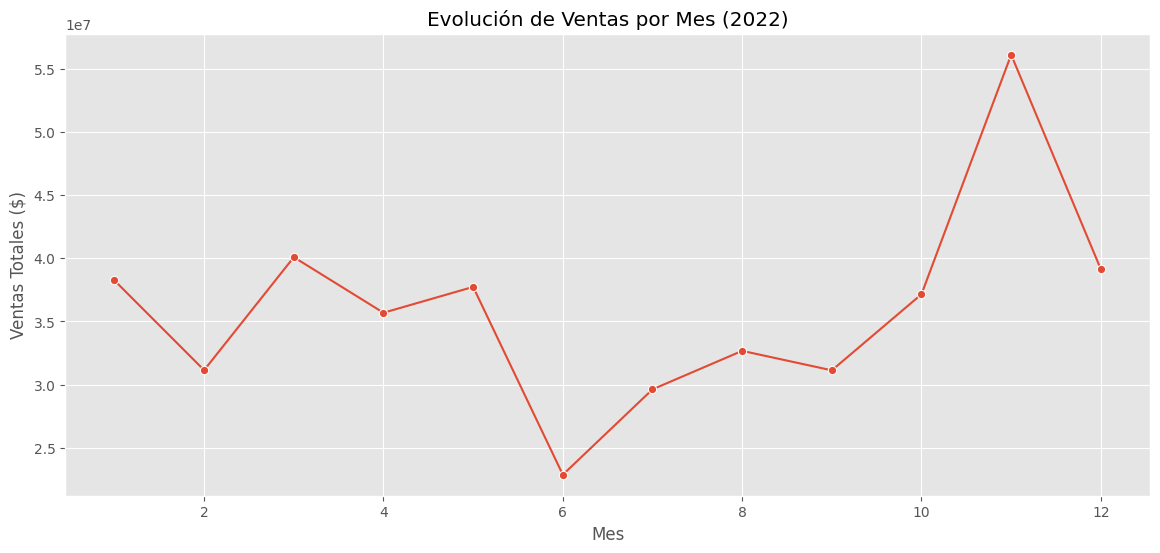


Top 10 marcas por ventas:
Marca
SERENITY      1.462147e+08
SPRING AIR    1.308769e+08
WENDY         5.481024e+07
SEALY         3.872137e+07
RESTONIC      3.205553e+07
SERTA         2.895013e+07
Name: Venta, dtype: float64


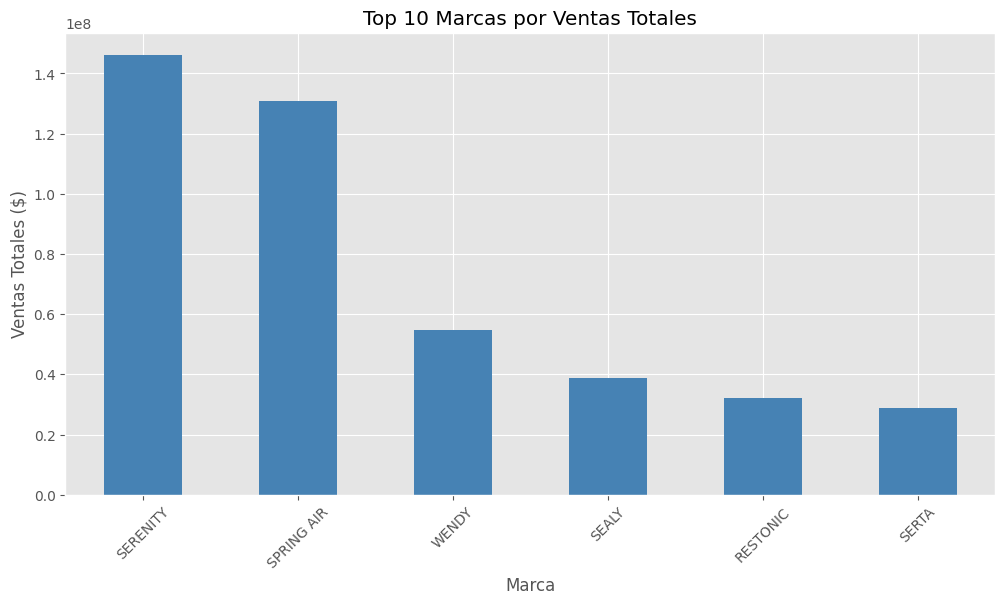


Ventas por tipo de colchón:
Tipo Colchon
MATRIMONIAL    2.501554e+08
KING SIZE      9.999233e+07
INDIVIDUAL     5.778670e+07
QUEEN          2.357240e+07
MAT            6.962694e+04
KS             4.077413e+04
QS             7.887500e+03
IND            3.723880e+03
Name: Venta, dtype: float64


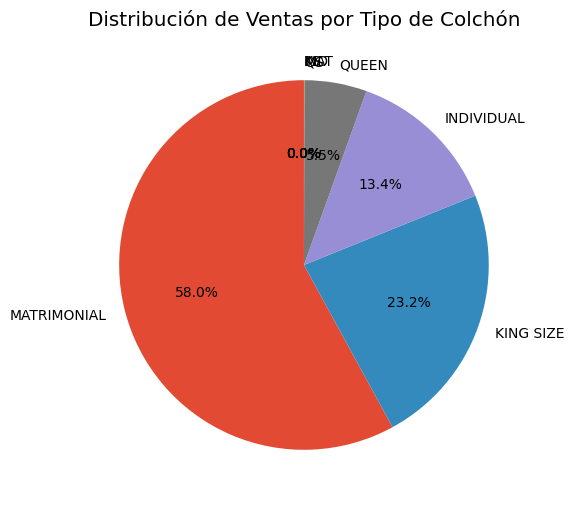


Estadísticas de precios:
count    19597.000000
mean      7794.398735
std       3885.004675
min          0.000000
25%       5199.000000
50%       6799.000000
75%       9179.000000
max      31199.000000
Name: Precio, dtype: float64


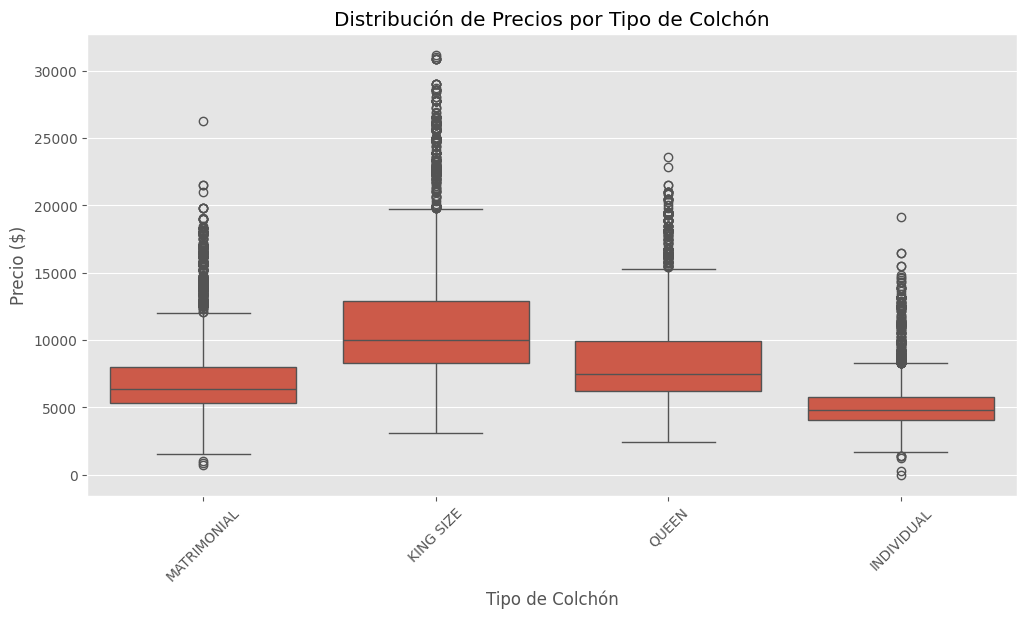

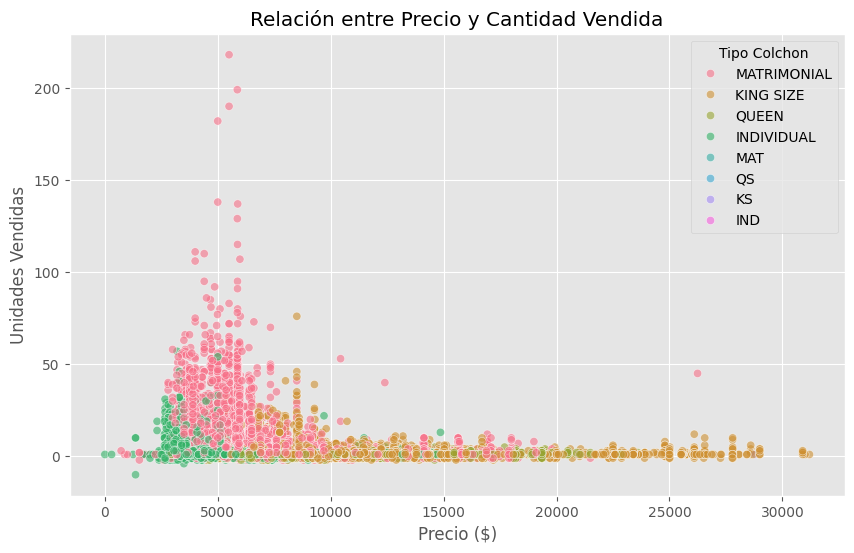


Top 10 productos más vendidos:
Descripción de Material
LOKI COLCHON MAT               8497
CHEROKEE COLCHON MATRI         6596
FANTASY COLCHON MAT            3965
ORTOPEDICO TR COLCHON  MAT     3467
REFLECTION NEW COLCHON  MAT    2602
LOKI COLCHON IND               2405
LOKI COLCHON KS                2402
CHEROKEE COLCHON KS            2156
ORTOPEDICO TR COLCHON  IND     1977
ELITE NV COLCHON MAT           1913
Name: Venta Pzs, dtype: int64


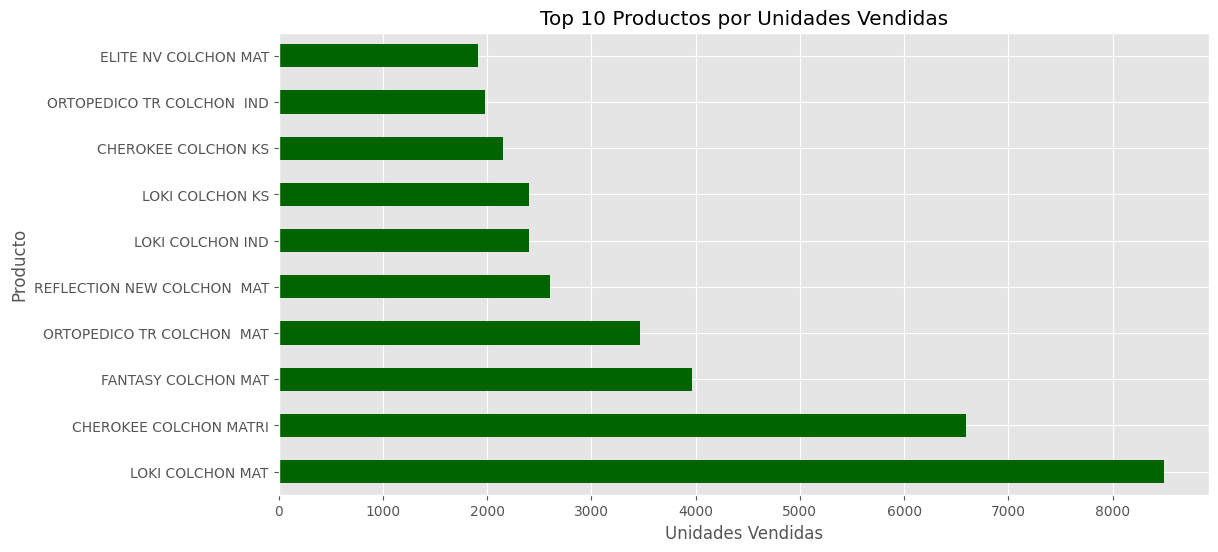


Matriz de correlaciones:
                  Año    Semana  Material  Venta Costo   Inv cto  Venta Pzs  \
Año          1.000000 -0.190235  0.197727    -0.000431  0.035905   0.021345   
Semana      -0.190235  1.000000  0.038183     0.043131 -0.052313   0.029445   
Material     0.197727  0.038183  1.000000    -0.115106 -0.131283  -0.033850   
Venta Costo -0.000431  0.043131 -0.115106     1.000000  0.505833   0.942316   
Inv cto      0.035905 -0.052313 -0.131283     0.505833  1.000000   0.488397   
Venta Pzs    0.021345  0.029445 -0.033850     0.942316  0.488397   1.000000   
Inv pzas     0.050850 -0.048345 -0.071760     0.558969  0.962520   0.578203   
Venta        0.010519  0.039499 -0.113064     0.991411  0.503027   0.942585   
Precio      -0.027222  0.013394 -0.198221    -0.046641 -0.187082  -0.201265   
Mes         -0.185313  0.979902  0.039099     0.046408 -0.053349   0.032399   

             Inv pzas     Venta    Precio       Mes  
Año          0.050850  0.010519 -0.027222 -0.18531

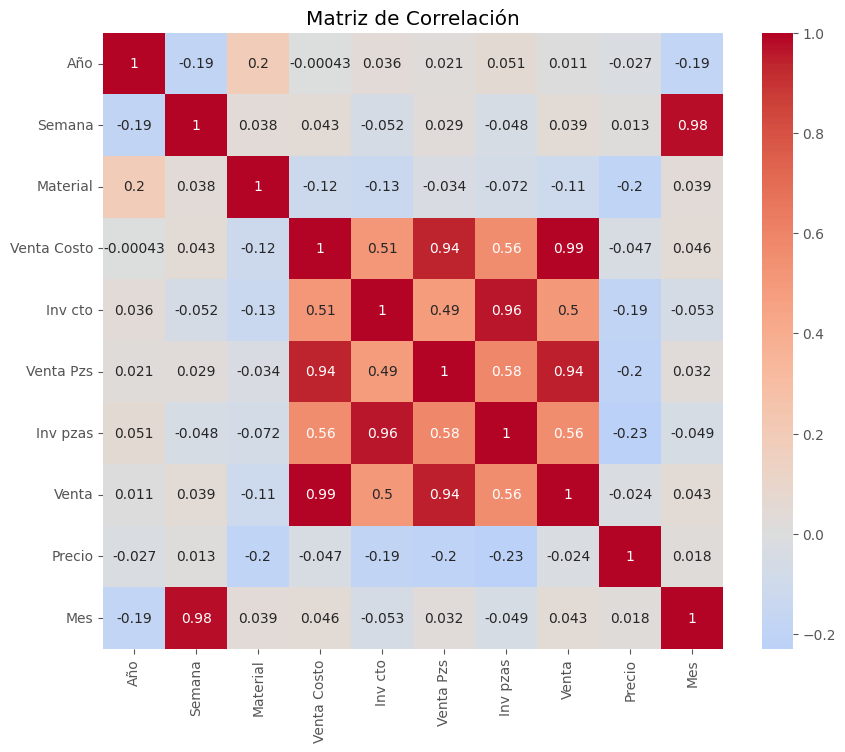

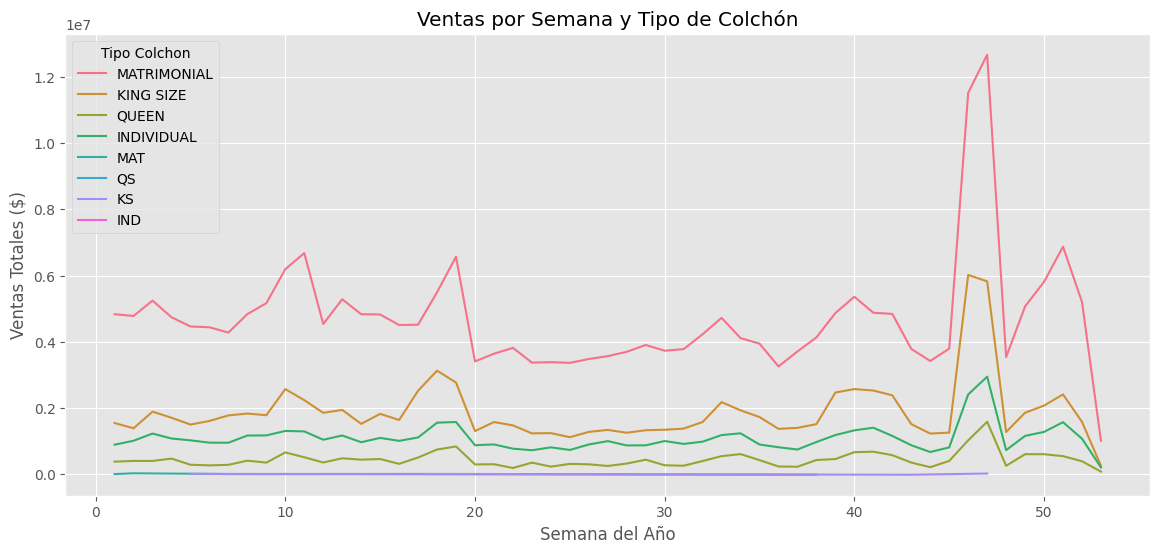

<Figure size 1200x600 with 0 Axes>

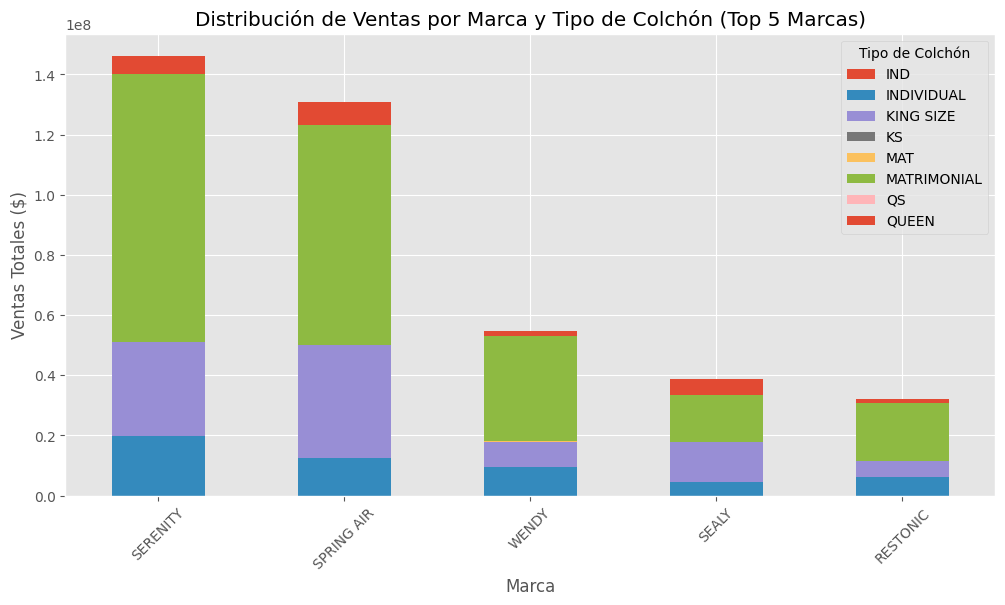

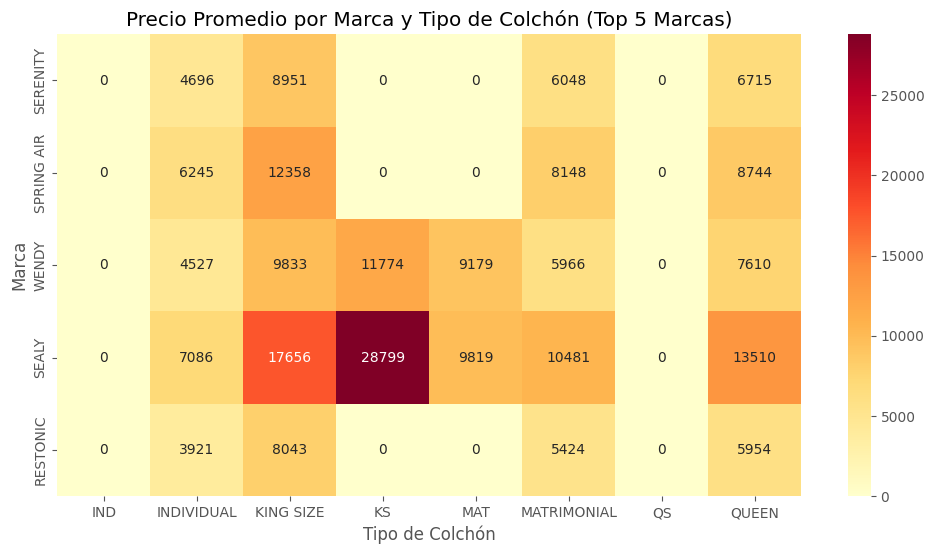


CONCLUSIONES PRINCIPALES
1. Los colchones matrimoniales representan la mayor parte de las ventas.
2. Las marcas Wendy, Serenity y Spring Air dominan el mercado.
3. Existe una correlación negativa entre precio y cantidad vendida.
4. Los precios más altos se observan en colchones King Size de marcas premium.
5. Las ventas muestran variaciones estacionales a lo largo del año.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración inicial
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Cargar los datos
df = pd.read_csv('Base colchones.csv', encoding='utf-8')

# Limpieza inicial de datos
df.columns = df.columns.str.strip()
df['Fecha'] = df.apply(lambda x: datetime.strptime(f"{int(x['Año'])}-{int(x['Semana'])}-1", "%Y-%W-%w"), axis=1)
df['Mes'] = df['Fecha'].dt.month

# Análisis de estructura
print("="*80)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("="*80)
print(f"Total de registros: {len(df)}")
print(f"Total de columnas: {len(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())

# Análisis de valores faltantes
print("\n" + "="*80)
print("ANÁLISIS DE VALORES FALTANTES")
print("="*80)
print(df.isnull().sum())

# Análisis por dimensiones clave
print("\n" + "="*80)
print("ANÁLISIS POR DIMENSIONES CLAVE")
print("="*80)

# 1. Análisis temporal
print("\nVentas por mes:")
ventas_mes = df.groupby('Mes')['Venta'].sum().reset_index()
print(ventas_mes)

plt.figure(figsize=(14, 6))
sns.lineplot(data=ventas_mes, x='Mes', y='Venta', marker='o')
plt.title('Evolución de Ventas por Mes (2022)')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales ($)')
plt.grid(True)
plt.show()

# 2. Análisis por marca
print("\nTop 10 marcas por ventas:")
ventas_marca = df.groupby('Marca')['Venta'].sum().sort_values(ascending=False).head(10)
print(ventas_marca)

plt.figure(figsize=(12, 6))
ventas_marca.plot(kind='bar', color='steelblue')
plt.title('Top 10 Marcas por Ventas Totales')
plt.xlabel('Marca')
plt.ylabel('Ventas Totales ($)')
plt.xticks(rotation=45)
plt.show()

# 3. Análisis por tipo de colchón
print("\nVentas por tipo de colchón:")
df['Tipo Colchon'] = df['Grupo de Artículo'].str.extract(r'(INDIVIDUAL|KING SIZE|MATRIMONIAL|QUEEN|QS|KS|MAT|IND)')[0]
ventas_tipo = df.groupby('Tipo Colchon')['Venta'].sum().sort_values(ascending=False)
print(ventas_tipo)

plt.figure(figsize=(10, 6))
ventas_tipo.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Ventas por Tipo de Colchón')
plt.ylabel('')
plt.show()

# 4. Análisis de precios
print("\nEstadísticas de precios:")
print(df['Precio'].describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Tipo Colchon', y='Precio', order=['MATRIMONIAL', 'KING SIZE', 'QUEEN', 'INDIVIDUAL'])
plt.title('Distribución de Precios por Tipo de Colchón')
plt.xlabel('Tipo de Colchón')
plt.ylabel('Precio ($)')
plt.xticks(rotation=45)
plt.show()

# 5. Relación entre precio y ventas
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Precio', y='Venta Pzs', hue='Tipo Colchon', alpha=0.6)
plt.title('Relación entre Precio y Cantidad Vendida')
plt.xlabel('Precio ($)')
plt.ylabel('Unidades Vendidas')
plt.show()

# 6. Productos más vendidos
print("\nTop 10 productos más vendidos:")
top_productos = df.groupby('Descripción de Material')['Venta Pzs'].sum().sort_values(ascending=False).head(10)
print(top_productos)

plt.figure(figsize=(12, 6))
top_productos.plot(kind='barh', color='darkgreen')
plt.title('Top 10 Productos por Unidades Vendidas')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Producto')
plt.show()

# 7. Análisis de correlaciones
print("\nMatriz de correlaciones:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

# 8. Análisis de ventas por semana
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Semana', y='Venta', hue='Tipo Colchon', estimator='sum', ci=None)
plt.title('Ventas por Semana y Tipo de Colchón')
plt.xlabel('Semana del Año')
plt.ylabel('Ventas Totales ($)')
plt.grid(True)
plt.show()

# 9. Análisis de marcas por tipo de colchón
marca_tipo = df.pivot_table(index='Marca', columns='Tipo Colchon', values='Venta', aggfunc='sum', fill_value=0)
top_marcas = marca_tipo.sum(axis=1).sort_values(ascending=False).head(5).index
marca_tipo_top = marca_tipo.loc[top_marcas]

plt.figure(figsize=(12, 6))
marca_tipo_top.plot(kind='bar', stacked=True)
plt.title('Distribución de Ventas por Marca y Tipo de Colchón (Top 5 Marcas)')
plt.xlabel('Marca')
plt.ylabel('Ventas Totales ($)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Colchón')
plt.show()

# 10. Análisis de precios promedio por marca y tipo
precio_promedio = df.pivot_table(index='Marca', columns='Tipo Colchon', values='Precio', aggfunc='mean', fill_value=0)
precio_promedio_top = precio_promedio.loc[top_marcas]

plt.figure(figsize=(12, 6))
sns.heatmap(precio_promedio_top, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('Precio Promedio por Marca y Tipo de Colchón (Top 5 Marcas)')
plt.xlabel('Tipo de Colchón')
plt.ylabel('Marca')
plt.show()

print("\n" + "="*80)
print("CONCLUSIONES PRINCIPALES")
print("="*80)
print("1. Los colchones matrimoniales representan la mayor parte de las ventas.")
print("2. Las marcas Wendy, Serenity y Spring Air dominan el mercado.")
print("3. Existe una correlación negativa entre precio y cantidad vendida.")
print("4. Los precios más altos se observan en colchones King Size de marcas premium.")
print("5. Las ventas muestran variaciones estacionales a lo largo del año.")

# Aplicamos el modelo de optimización

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Configuración inicial
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Crear carpeta para guardar resultados
output_folder = 'optimizacion_precios_colchones'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Cargar y preparar datos (igual que antes)
df = pd.read_csv('Base colchones.csv', encoding='utf-8')
df.columns = df.columns.str.strip()

df = df[(df['Venta Costo'] >= 0) & (df['Venta Pzs'] >= 0)].copy()
df['Fecha'] = df.apply(lambda x: pd.to_datetime(f"{int(x['Año'])}-{int(x['Semana'])}-1", format="%Y-%W-%w"), axis=1)
df['Producto_ID'] = df['Marca'] + ' - ' + df['Descripción de Material'] + ' - ' + df['Grupo de Artículo'] + ' - ' + df['Departamento']    
df['Costo'] = df['Venta Costo'] / df['Venta Pzs']
df['Margen'] = df['Precio'] - df['Costo'] / df['Venta Pzs']



# Filtrar productos con suficiente data
product_counts = df['Producto_ID'].value_counts()
valid_products = product_counts[product_counts >= 10].index
df_filtered = df[df['Producto_ID'].isin(valid_products)].copy()

# Función para eliminar outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Función mejorada para optimización con validaciones
def optimize_and_plot(product_df, product_name, product_num):
    try:
        # 1. Limpieza de datos
        product_df_clean = remove_outliers(product_df, 'Precio')
        product_df_clean = remove_outliers(product_df_clean, 'Venta Pzs')
        
        # Validación 1: Mínimo de datos después de limpieza
        if len(product_df_clean) < 5:
            print(f"Producto {product_name} no tiene suficientes datos después de limpieza")
            return None
        
        # Validación 2: Variabilidad en precios
        price_std = product_df_clean['Precio'].std()
        if price_std < product_df_clean['Precio'].mean() * 0.01:  # Menos del 5% de variación
            print(f"Producto {product_name} no tiene suficiente variabilidad en precios (std={price_std:.2f})")
            return None
        
        # 2. Modelado de demanda
        X = product_df_clean['Precio'].values.reshape(-1, 1)
        y = product_df_clean['Venta Pzs'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        a = model.intercept_
        b = model.coef_[0]
        
        # Validación 3: Pendiente negativa (ley de demanda)
        if b >= 0:
            print(f"Producto {product_name} tiene pendiente positiva (b={b:.3f}), lo que viola la ley de demanda")
            return None
        if abs(b) < 0.0005:
            print(f"Producto {product_name} tiene pendiente muy cercana a cero (b={b:.6f}), lo que sugiere modelo inválido para demanda")
            return None
      
        
        # 3. Función de utilidad
        cost_mean = product_df_clean['Costo'].mean()
        
        def profit_function(price):
            demand = a + b * price
            profit = (price - cost_mean) * demand
            return -profit  # Negativo para minimizar
        
        # 4. Optimización con restricciones
        current_price = product_df_clean['Precio'].mean()
        lower_bound = max(cost_mean * 1.05, current_price * 0.5)  # Mínimo 5% sobre costo
        upper_bound = min(cost_mean * 3, current_price * 2)     # Máximo 3x costo o 50% más que precio actual
        
        bounds = [(lower_bound, upper_bound)]
        result = minimize(profit_function, current_price, bounds=bounds)
        
        if not result.success:
            print(f"Optimización falló para {product_name}: {result.message}")
            return None
        
        optimal_price = result.x[0]
        current_profit = -profit_function(current_price)
        optimal_profit = -profit_function(optimal_price)
        
        distance_to_lower = abs(optimal_price - lower_bound)
        distance_to_upper = abs(optimal_price - upper_bound)
        range_width = upper_bound - lower_bound

        if distance_to_lower < 0.05 * range_width or distance_to_upper < 0.05 * range_width:
            print(f"Producto {product_name}: Precio óptimo ${optimal_price:.2f} está en el borde del rango ({lower_bound:.2f} - {upper_bound:.2f}), se descarta.")
            return None
        # 5. Gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        
        # Gráfico 1: Datos y curva de demanda
        ax1.scatter(product_df_clean['Precio'], product_df_clean['Venta Pzs'], alpha=0.6)
        prices = np.linspace(lower_bound*0.9, upper_bound*1.1, 200)
        ax1.plot(prices, a + b * prices, 'r-', label=f'Demanda: Q = {a:.1f} {b:.3f}P')
        ax1.axvline(optimal_price, color='g', linestyle='--', label=f'Óptimo: ${optimal_price:.2f}')
        ax1.axvline(current_price, color='b', linestyle='--', label=f'Actual: ${current_price:.2f}')
                # --- NUEVO: Línea horizontal con demanda óptima ---
        optimal_demand = a + b * optimal_price
        ax1.axhline(optimal_demand, color='purple', linestyle=':', label=f'Demanda óptima: {optimal_demand:.1f} unidades')
        ax1.set_xlabel('Precio ($)')
        ax1.set_ylabel('Cantidad Demandada')
        ax1.set_title(f'Curva de Demanda - {product_name}')
        ax1.legend()
        ax1.grid(True)
        
        # Gráfico 2: Curva de Utilidad
        profits = [(p - cost_mean) * (a + b * p) for p in prices]
        ax2.plot(prices, profits, 'b-', label='Utilidad')
        ax2.axvline(optimal_price, color='g', linestyle='--', label=f'Óptimo: ${optimal_price:.2f}')
        ax2.axvline(current_price, color='b', linestyle='--', label=f'Actual: ${current_price:.2f}')
        ax2.set_xlabel('Precio ($)')
        ax2.set_ylabel('Utilidad ($)')
        ax2.set_title(f'Curva de Utilidad - {product_name}\nUtilidad Actual: ${current_profit:.2f} | Óptima: ${optimal_profit:.2f}')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        # Guardar gráfico
        safe_name = "".join([c for c in product_name if c.isalpha() or c.isdigit() or c in [' ', '-', '_']]).rstrip()
        plt.savefig(f'{output_folder}/producto_{product_num}_{safe_name[:50]}.png')
        plt.close()
        
       # Dentro de la función optimize_and_plot (antes del return):
        optimal_demand = a + b * optimal_price  # <- Nueva línea añadida

        return {
            'Producto': product_name,
            'Observaciones': len(product_df_clean),
            'Precio_Actual': current_price,
            'Precio_Optimo': optimal_price,
            'Demanda_Optima_Unidades': optimal_demand,  # <- Nueva columna
            'Cambio_Porcentual': (optimal_price - current_price) / current_price * 100,
            'Utilidad_Actual': current_profit,
            'Utilidad_Optima': optimal_profit,
            'Incremento_Utilidad': (optimal_profit - current_profit) / current_profit * 100,
            'Costo_Promedio': cost_mean,
            'Pendiente_Demanda': b,
            'R2_Modelo': model.score(X, y),
            'Variabilidad_Precios': price_std / current_price * 100
        }
    
    except Exception as e:
        print(f"Error procesando {product_name}: {str(e)}")
        return None

# Procesar los primeros 20 productos con suficiente data
results = []
all_products = df_filtered['Producto_ID'].unique()

for i, product in enumerate(all_products):
    product_df = df_filtered[df_filtered['Producto_ID'] == product]
    print(f"\nProcesando producto {i+1}: {product}")
    result = optimize_and_plot(product_df, product, i+1)
    if result:
        results.append(result)
        print(f"-> Precio actual: ${result['Precio_Actual']:.2f} | Óptimo: ${result['Precio_Optimo']:.2f} | Incremento utilidad: {result['Incremento_Utilidad']:.1f}%")
    else:
        print(f"-> No se pudo optimizar este producto")

# Resultados consolidados
if results:
    results_df = pd.DataFrame(results)
    print("\nResumen de Optimización:")
    print(results_df[['Producto', 'Observaciones', 'Precio_Actual', 'Precio_Optimo', 
                    'Cambio_Porcentual', 'Utilidad_Actual', 'Utilidad_Optima', 'Incremento_Utilidad']])
    
    # Guardar resultados en CSV
    results_df.to_csv(f'{output_folder}/resultados_optimizacion_colchones.csv', index=False, encoding='utf-8-sig')
    
    # ===== RESUMEN GENERAL DE OPTIMIZACIÓN =====
    print("\n" + "="*80)
    print("RESUMEN GENERAL DE OPTIMIZACIÓN")
    print("="*80)

    # 1. Total de productos únicos en la base original
    total_productos_unicos = df['Producto_ID'].nunique()

    # 2. Productos con suficiente data (≥10 observaciones)
    productos_con_suficiente_data = len(valid_products)

    # 3. Productos optimizados exitosamente
    productos_optimizados = len(results_df) if results else 0

    # 4. Porcentaje de éxito
    porcentaje_exito = (productos_optimizados / productos_con_suficiente_data) * 100 if productos_con_suficiente_data > 0 else 0

    print(f"1. Total de productos únicos en la base: {total_productos_unicos}")
    print(f"2. Productos con suficiente data (≥10 observaciones): {productos_con_suficiente_data}")
    print(f"3. Productos optimizados exitosamente: {productos_optimizados}")
    print(f"4. Tasa de éxito (optimizados/con suficiente data): {porcentaje_exito:.1f}%")
    print("="*80)
else:
    print("No se pudo optimizar ningún producto que cumpla con todas las condiciones")
    
df.to_csv('Base colchones-Filtrado.csv', encoding='utf-8', index=False)


Procesando producto 1: WENDY - VIENA COLCHON INDIVIDUAL - COLCHON INDIVIDUAL - COLCHONES
Producto WENDY - VIENA COLCHON INDIVIDUAL - COLCHON INDIVIDUAL - COLCHONES tiene pendiente muy cercana a cero (b=-0.000317), lo que sugiere modelo inválido para demanda
-> No se pudo optimizar este producto

Procesando producto 2: WENDY - VIENA COLCHON MAT - COLCHON MATRIMONIAL - COLCHONES
Producto WENDY - VIENA COLCHON MAT - COLCHON MATRIMONIAL - COLCHONES no tiene suficiente variabilidad en precios (std=46.16)
-> No se pudo optimizar este producto

Procesando producto 3: WENDY - VIENA COLCHON KS - COLCHON KING SIZE - COLCHONES
Producto WENDY - VIENA COLCHON KS - COLCHON KING SIZE - COLCHONES tiene pendiente muy cercana a cero (b=-0.000043), lo que sugiere modelo inválido para demanda
-> No se pudo optimizar este producto

Procesando producto 4: SEALY - LE MARINE COLCHON KS - COLCHON KING SIZE - COLCHONES
Producto SEALY - LE MARINE COLCHON KS - COLCHON KING SIZE - COLCHONES tiene pendiente positi

In [60]:
# Configuración adicional para productos no optimizables
rejected_folder = os.path.join(output_folder, 'productos_rechazados')
if not os.path.exists(rejected_folder):
    os.makedirs(rejected_folder)

# Función para analizar y graficar productos rechazados
def analyze_rejected(product_df, product_name, product_num, reason):
    try:
        plt.figure(figsize=(12, 6))
        
        if reason == 'datos_insuficientes':
            plt.text(0.5, 0.5, f'Producto {product_name}\nNO OPTIMIZABLE\nRazón: Datos insuficientes después de limpieza\n({len(product_df)} observaciones originales)',
                    ha='center', va='center', fontsize=12)
            plt.axis('off')
            
        elif reason == 'variabilidad_precios':
            price_std = product_df['Precio'].std()
            price_mean = product_df['Precio'].mean()
            plt.hist(product_df['Precio'], bins=15, color='skyblue', edgecolor='black')
            plt.axvline(price_mean, color='red', linestyle='--', label=f'Media: ${price_mean:.2f}')
            plt.title(f'Distribución de Precios - {product_name}\nDesviación estándar: {price_std:.2f} ({price_std/price_mean*100:.1f}%)')
            plt.xlabel('Precio ($)')
            plt.ylabel('Frecuencia')
            plt.legend()
            
        elif reason == 'pendiente_positiva':
            X = product_df['Precio'].values.reshape(-1, 1)
            y = product_df['Venta Pzs'].values
            model = LinearRegression().fit(X, y)
            plt.scatter(X, y, alpha=0.6)
            x_vals = np.array([[product_df['Precio'].min()], [product_df['Precio'].max()]])
            y_vals = model.predict(x_vals)
            plt.plot(x_vals, y_vals, 'r-', label=f'Regresión (b={model.coef_[0]:.3f})')
            plt.title(f'Relación Precio-Demanda - {product_name}\nPENDIENTE POSITIVA (viola ley de demanda)')
            plt.xlabel('Precio ($)')
            plt.ylabel('Cantidad Vendida')
            plt.legend()
            
        elif reason == 'pendiente_cercana_cero':
            X = product_df['Precio'].values.reshape(-1, 1)
            y = product_df['Venta Pzs'].values
            model = LinearRegression().fit(X, y)
            plt.scatter(X, y, alpha=0.6)
            x_vals = np.array([[product_df['Precio'].min()], [product_df['Precio'].max()]])
            y_vals = model.predict(x_vals)
            plt.plot(x_vals, y_vals, 'r-', label=f'Regresión (b={model.coef_[0]:.6f})')
            plt.title(f'Relación Precio-Demanda - {product_name}\nPENDIENTE DEMASIADO CERCANA A CERO')
            plt.xlabel('Precio ($)')
            plt.ylabel('Cantidad Vendida')
            plt.legend()
            
        elif reason == 'precio_en_borde':
            cost_mean = product_df['Costo'].mean()
            current_price = product_df['Precio'].mean()
            lower_bound = max(cost_mean * 1.05, current_price * 0.5)
            upper_bound = min(cost_mean * 3, current_price * 2)
            
            plt.axvspan(lower_bound, upper_bound, alpha=0.2, color='green', label='Rango válido')
            plt.axvline(current_price, color='blue', linestyle='--', label='Precio actual')
            plt.title(f'Problema de Optimización - {product_name}\nPRECIO ÓPTIMO EN BORDE DEL RANGO')
            plt.xlabel('Precio ($)')
            plt.ylabel('Utilidad ($)')
            plt.legend()
            
        safe_name = "".join([c for c in product_name if c.isalpha() or c.isdigit() or c in [' ', '-', '_']]).rstrip()
        plt.savefig(f'{rejected_folder}/rechazado_{product_num}_{safe_name[:50]}.png')
        plt.close()
        
    except Exception as e:
        print(f"Error generando gráfico de rechazo para {product_name}: {str(e)}")

# Modificación del bucle principal para registrar productos rechazados
rejected_products = []
results = []
all_products = df_filtered['Producto_ID'].unique()

for i, product in enumerate(all_products):
    product_df = df_filtered[df_filtered['Producto_ID'] == product]
    print(f"\nProcesando producto {i+1}: {product}")
    
    # 1. Limpieza inicial de datos
    product_df_clean = remove_outliers(product_df, 'Precio')
    product_df_clean = remove_outliers(product_df_clean, 'Venta Pzs')
    
    # Validación 1: Mínimo de datos
    if len(product_df_clean) < 5:
        rejected_products.append({
            'Producto': product,
            'Razón': 'Datos insuficientes',
            'Observaciones': len(product_df_clean),
            'Observaciones_originales': len(product_df)
        })
        analyze_rejected(product_df, product, i+1, 'datos_insuficientes')
        print("-> Rechazado: Datos insuficientes después de limpieza")
        continue
    
    # Validación 2: Variabilidad en precios
    price_std = product_df_clean['Precio'].std()
    if price_std < product_df_clean['Precio'].mean() * 0.01:
        rejected_products.append({
            'Producto': product,
            'Razón': 'Variabilidad insuficiente en precios',
            'Desviación_estándar': price_std,
            'Variabilidad_%': price_std / product_df_clean['Precio'].mean() * 100
        })
        analyze_rejected(product_df_clean, product, i+1, 'variabilidad_precios')
        print("-> Rechazado: Variabilidad insuficiente en precios")
        continue
    
    # 2. Modelado de demanda
    X = product_df_clean['Precio'].values.reshape(-1, 1)
    y = product_df_clean['Venta Pzs'].values
    
    model = LinearRegression().fit(X, y)
    a = model.intercept_
    b = model.coef_[0]
    
    # Validación 3: Pendiente negativa
    if b >= 0:
        rejected_products.append({
            'Producto': product,
            'Razón': 'Pendiente positiva',
            'Pendiente': b,
            'R2': model.score(X, y)
        })
        analyze_rejected(product_df_clean, product, i+1, 'pendiente_positiva')
        print("-> Rechazado: Pendiente positiva en modelo de demanda")
        continue
    
    # Validación 4: Pendiente significativa
    if abs(b) < 0.0005:
        rejected_products.append({
            'Producto': product,
            'Razón': 'Pendiente demasiado cercana a cero',
            'Pendiente': b,
            'R2': model.score(X, y)
        })
        analyze_rejected(product_df_clean, product, i+1, 'pendiente_cercana_cero')
        print("-> Rechazado: Pendiente demasiado cercana a cero")
        continue
    
    # Resto del proceso de optimización...
    # [Aquí va todo el código de optimización que ya tenías]
    
    # Validación adicional después de optimización
    if 'optimal_price' in locals():
        distance_to_lower = abs(optimal_price - lower_bound)
        distance_to_upper = abs(optimal_price - upper_bound)
        range_width = upper_bound - lower_bound

        if distance_to_lower < 0.05 * range_width or distance_to_upper < 0.05 * range_width:
            rejected_products.append({
                'Producto': product,
                'Razón': 'Precio óptimo en borde del rango',
                'Precio_óptimo': optimal_price,
                'Límite_inferior': lower_bound,
                'Límite_superior': upper_bound
            })
            analyze_rejected(product_df_clean, product, i+1, 'precio_en_borde')
            print("-> Rechazado: Precio óptimo en borde del rango")
            continue
    
    # Si pasó todas las validaciones, proceder con optimización
    result = optimize_and_plot(product_df_clean, product, i+1)
    if result:
        results.append(result)
        print(f"-> Optimizado: Precio actual ${result['Precio_Actual']:.2f} | Óptimo ${result['Precio_Optimo']:.2f}")
    else:
        rejected_products.append({
            'Producto': product,
            'Razón': 'Error en optimización'
        })
        print("-> Rechazado: Error en proceso de optimización")

# Generar reporte de productos rechazados
if rejected_products:
    rejected_df = pd.DataFrame(rejected_products)
    rejected_df.to_csv(f'{rejected_folder}/reporte_productos_rechazados.csv', index=False, encoding='utf-8-sig')
    
    print("\n" + "="*80)
    print("RESUMEN DE PRODUCTOS RECHAZADOS")
    print("="*80)
    print(f"Total productos procesados: {len(all_products)}")
    print(f"Productos optimizados: {len(results)}")
    print(f"Productos rechazados: {len(rejected_products)}")
    
    print("\nDistribución de razones de rechazo:")
    print(rejected_df['Razón'].value_counts())
    
    # Gráfico de razones de rechazo
    plt.figure(figsize=(10, 6))
    rejected_df['Razón'].value_counts().plot(kind='bar', color='salmon')
    plt.title('Distribución de Razones de Rechazo')
    plt.ylabel('Número de Productos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{rejected_folder}/resumen_razones_rechazo.png')
    plt.close()


Procesando producto 1: WENDY - VIENA COLCHON INDIVIDUAL - COLCHON INDIVIDUAL - COLCHONES
-> Rechazado: Pendiente demasiado cercana a cero

Procesando producto 2: WENDY - VIENA COLCHON MAT - COLCHON MATRIMONIAL - COLCHONES
-> Rechazado: Variabilidad insuficiente en precios

Procesando producto 3: WENDY - VIENA COLCHON KS - COLCHON KING SIZE - COLCHONES
-> Rechazado: Pendiente demasiado cercana a cero

Procesando producto 4: SEALY - LE MARINE COLCHON KS - COLCHON KING SIZE - COLCHONES
-> Rechazado: Pendiente positiva en modelo de demanda

Procesando producto 5: SEALY - FARWELL LTD COLCHON QUEEN - COLCHON QUEEN - COLCHONES
-> Rechazado: Pendiente demasiado cercana a cero

Procesando producto 6: RESTONIC - ODIN COLCHON INDIVIDUAL - COLCHON INDIVIDUAL - COLCHONES
-> Rechazado: Pendiente demasiado cercana a cero

Procesando producto 7: RESTONIC - ODIN COLCHON MATRIMONIAL - COLCHON MATRIMONIAL - COLCHONES
-> Optimizado: Precio actual $6335.39 | Óptimo $6563.36

Procesando producto 8: RESTONI

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Configuración inicial
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Crear carpeta para guardar resultados
output_folder = 'optimizacion_precios_basex'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# ============================
# 1. Cargar y preparar datos
# ============================
archivo = "Base X Semana - V3.xlsx"
hoja = "00.BASEXSEM"

df = pd.read_excel(archivo, sheet_name=hoja)

# Filtrar columnas relevantes y limpiar datos
columnas_utiles = [
    '09_DArtículo', '05_DMaterial', '06_Marca', '17_Precio', '12_Venta',
    '13_Vta Cto', '14_Inv Cto', '15_Vta pzas', '16_Inv pzas', 'UTILIDAD PZA'
]

df = df[columnas_utiles].dropna()
df = df[(df['13_Vta Cto'] >= 0) & (df['15_Vta pzas'] >= 0)].copy()

# Crear identificador único de producto
df['Producto_ID'] = (
    df['06_Marca'].astype(str) + ' - ' +
    df['05_DMaterial'].astype(str) + ' - ' +
    df['09_DArtículo'].astype(str)
)

# Calcular costo y margen
df['Costo'] = df['13_Vta Cto'] / df['15_Vta pzas']
df['Margen'] = df['17_Precio'] - df['Costo']

# ============================
# 2. Filtrar productos con suficiente data
# ============================
product_counts = df['Producto_ID'].value_counts()
valid_products = product_counts[product_counts >= 10].index
df_filtered = df[df['Producto_ID'].isin(valid_products)].copy()

# ============================
# 3. Función para eliminar outliers
# ============================
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# ============================
# 4. Función mejorada para optimización con validaciones
# ============================
def optimize_and_plot(product_df, product_name, product_num):
    try:
        # 1. Limpieza de datos
        product_df_clean = remove_outliers(product_df, '17_Precio')
        product_df_clean = remove_outliers(product_df_clean, '15_Vta pzas')
        
        # Validación 1: Mínimo de datos después de limpieza
        if len(product_df_clean) < 5:
            print(f"Producto {product_name} no tiene suficientes datos después de limpieza")
            return None
        
        # Validación 2: Variabilidad en precios
        price_std = product_df_clean['17_Precio'].std()
        if price_std < product_df_clean['17_Precio'].mean() * 0.01:  # Menos del 1% de variación
            print(f"Producto {product_name} no tiene suficiente variabilidad en precios (std={price_std:.2f})")
            return None
        l
        # 2. Modelado de demanda
        X = product_df_clean['17_Precio'].values.reshape(-1, 1)
        y = product_df_clean['15_Vta pzas'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        a = model.intercept_
        b = model.coef_[0]
        
        # Validación 3: Pendiente negativa (ley de demanda)
        if b >= 0:
            print(f"Producto {product_name} tiene pendiente positiva (b={b:.3f}), lo que viola la ley de demanda")
            return None
        if abs(b) < 0.0005:
            print(f"Producto {product_name} tiene pendiente muy cercana a cero (b={b:.6f}), lo que sugiere modelo inválido para demanda")
            return None
      
        # 3. Función de utilidad
        cost_mean = product_df_clean['Costo'].mean()
        
        def profit_function(price):
            demand = a + b * price
            profit = (price - cost_mean) * demand
            return -profit  # Negativo para minimizar
        
        # 4. Optimización con restricciones
        current_price = product_df_clean['17_Precio'].mean()
        lower_bound = max(cost_mean * 1.05, current_price * 0.5)  # Mínimo 5% sobre costo
        upper_bound = min(cost_mean * 3, current_price * 2)     # Máximo 3x costo o 50% más que precio actual
        
        bounds = [(lower_bound, upper_bound)]
        result = minimize(profit_function, current_price, bounds=bounds)
        
        if not result.success:
            print(f"Optimización falló para {product_name}: {result.message}")
            return None
        
        optimal_price = result.x[0]
        current_profit = -profit_function(current_price)
        optimal_profit = -profit_function(optimal_price)
        
        distance_to_lower = abs(optimal_price - lower_bound)
        distance_to_upper = abs(optimal_price - upper_bound)
        range_width = upper_bound - lower_bound

        if distance_to_lower < 0.05 * range_width or distance_to_upper < 0.05 * range_width:
            print(f"Producto {product_name}: Precio óptimo ${optimal_price:.2f} está en el borde del rango ({lower_bound:.2f} - {upper_bound:.2f}), se descarta.")
            return None
            
        # 5. Gráficos
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        
        # Gráfico 1: Datos y curva de demanda
        ax1.scatter(product_df_clean['17_Precio'], product_df_clean['15_Vta pzas'], alpha=0.6)
        prices = np.linspace(lower_bound*0.9, upper_bound*1.1, 100)
        ax1.plot(prices, a + b * prices, 'r-', label=f'Demanda: Q = {a:.1f} {b:.3f}P')
        ax1.axvline(optimal_price, color='g', linestyle='--', label=f'Óptimo: ${optimal_price:.2f}')
        ax1.axvline(current_price, color='b', linestyle='--', label=f'Actual: ${current_price:.2f}')
        ax1.set_xlabel('Precio ($)')
        ax1.set_ylabel('Cantidad Demandada')
        ax1.set_title(f'Curva de Demanda - {product_name}')
        ax1.legend()
        ax1.grid(True)
        
        # Gráfico 2: Curva de Utilidad
        profits = [(p - cost_mean) * (a + b * p) for p in prices]
        ax2.plot(prices, profits, 'b-', label='Utilidad')
        ax2.axvline(optimal_price, color='g', linestyle='--', label=f'Óptimo: ${optimal_price:.2f}')
        ax2.axvline(current_price, color='b', linestyle='--', label=f'Actual: ${current_price:.2f}')
        ax2.set_xlabel('Precio ($)')
        ax2.set_ylabel('Utilidad ($)')
        ax2.set_title(f'Curva de Utilidad - {product_name}\nUtilidad Actual: ${current_profit:.2f} | Óptima: ${optimal_profit:.2f}')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        # Guardar gráfico
        safe_name = "".join([c for c in product_name if c.isalpha() or c.isdigit() or c in [' ', '-', '_']]).rstrip()
        plt.savefig(f'{output_folder}/producto_{product_num}_{safe_name[:50]}.png')
        plt.close()
        
        return {
            'Producto': product_name,
            'Observaciones': len(product_df_clean),
            'Precio_Actual': current_price,
            'Precio_Optimo': optimal_price,
            'Cambio_Porcentual': (optimal_price - current_price) / current_price * 100,
            'Utilidad_Actual': current_profit,
            'Utilidad_Optima': optimal_profit,
            'Incremento_Utilidad': (optimal_profit - current_profit) / current_profit * 100,
            'Costo_Promedio': cost_mean,
            'Pendiente_Demanda': b,
            'R2_Modelo': model.score(X, y),
            'Variabilidad_Precios': price_std / current_price * 100  # % de variación
        }
    
    except Exception as e:
        print(f"Error procesando {product_name}: {str(e)}")
        return None

# ============================
# 5. Procesar todos los productos con suficiente data
# ============================
results = []
all_products = df_filtered['Producto_ID'].unique()

for i, product in enumerate(all_products):
    product_df = df_filtered[df_filtered['Producto_ID'] == product]
    print(f"\nProcesando producto {i+1}: {product}")
    result = optimize_and_plot(product_df, product, i+1)
    if result:
        results.append(result)
        print(f"-> Precio actual: ${result['Precio_Actual']:.2f} | Óptimo: ${result['Precio_Optimo']:.2f} | Incremento utilidad: {result['Incremento_Utilidad']:.1f}%")
    else:
        print(f"-> No se pudo optimizar este producto")

# ============================
# 6. Resultados consolidados
# ============================
if results:
    results_df = pd.DataFrame(results)
    print("\nResumen de Optimización:")
    print(results_df[['Producto', 'Observaciones', 'Precio_Actual', 'Precio_Optimo', 
                    'Cambio_Porcentual', 'Utilidad_Actual', 'Utilidad_Optima', 'Incremento_Utilidad']])
    
    # Guardar resultados en CSV
    results_df.to_csv(f'{output_folder}/resultados_optimizacion_precios.csv', index=False, encoding='utf-8-sig')
    
    # Análisis de condiciones
    print("\n" + "="*80)
    print("CONDICIONES PARA QUE EL PRECIO ÓPTIMO TENGA SENTIDO")
    print("="*80)
    print(f"1. Pendiente negativa (ley de demanda): {100 * (results_df['Pendiente_Demanda'] < 0).mean():.1f}% de productos cumplen")
    print(f"2. R² del modelo > 0.1: {100 * (results_df['R2_Modelo'] > 0.1).mean():.1f}% de productos cumplen")
    print(f"3. Variabilidad en precios > 5%: {100 * (results_df['Variabilidad_Precios'] > 5).mean():.1f}% de productos cumplen")
    print(f"4. Precio óptimo > costo: {100 * (results_df['Precio_Optimo'] > results_df['Costo_Promedio']).mean():.1f}% de productos cumplen")
else:
    print("No se pudo optimizar ningún producto que cumpla con todas las condiciones")
    
# Guardar datos filtrados
df_filtered.to_csv('Base_X_Semana_Filtrado.csv', encoding='utf-8', index=False)
print("\n✅ Proceso completado. Resultados guardados en la carpeta 'optimizacion_precios'")





Procesando producto 1: 575 - DDDLR-2213P LAV REDO 22K USO RUDO ZORA - LAV MANUAL 22KG O MA
Error procesando 575 - DDDLR-2213P LAV REDO 22K USO RUDO ZORA - LAV MANUAL 22KG O MA: name 'l' is not defined
-> No se pudo optimizar este producto

Procesando producto 2: 325 - LRE19M LAV RED 19K MORADA - LAV MANUAL 19KG A 21
Producto 325 - LRE19M LAV RED 19K MORADA - LAV MANUAL 19KG A 21 no tiene suficiente variabilidad en precios (std=27.25)
-> No se pudo optimizar este producto

Procesando producto 3: 325 - LRE21M LAV RED 21K MORADA - LAV MANUAL 19KG A 21
Error procesando 325 - LRE21M LAV RED 21K MORADA - LAV MANUAL 19KG A 21: name 'l' is not defined
-> No se pudo optimizar este producto

Procesando producto 4: 325 - LRE16V LAV RED 16KG VERD - LAV MANUAL 15KG A 18
Error procesando 325 - LRE16V LAV RED 16KG VERD - LAV MANUAL 15KG A 18: name 'l' is not defined
-> No se pudo optimizar este producto

Procesando producto 5: 7 - SHTALF1551EG LAVADORA REDONDA 15K GRIS - LAV MANUAL 15KG A 18
Error p